In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt


from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from progressbar import ProgressBar
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from matplotlib import cm
from sklearn import datasets
from sklearn.manifold import TSNE



#### This is the same mapping seen in other notebooks. Used for converting label id to a name for understanding results better

In [3]:
TARGET_CLASSES_MAPPING = {}
TARGET_CLASSES_MAPPING[10419] = 'Qutub Minar'
TARGET_CLASSES_MAPPING[47378] = 'Eiffel Tower'
TARGET_CLASSES_MAPPING[168098] = 'Golden Gate Bridge'
TARGET_CLASSES_MAPPING[162833] = 'Pakistan Monument'
TARGET_CLASSES_MAPPING[1924] = 'Niagara River'

In [4]:
sift = cv2.SIFT_create()

In [5]:
img_path = '../TargetImages/'
train = pd.read_csv('TargetData-TF-Train.csv')
landmarks = train['landmark_id'].sort_values().unique()

# Array to store the oringal sift descriptors
dico = []


for leaf in train.id:
    # create path to image and variable allocation
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    for d in des:
        # append the descriptors to the descriptor list
        dico.append(d)

##### Length of the initial sift is 128

In [6]:
len(dico[0])

128

In [7]:

# Create 5 * 10 center means ( 5 = num classes we have)
k = np.size(landmarks) * 10

# set the batch size and fit to the descriptors.
batch_size = np.size(os.listdir(img_path)) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

Init 1/3 with method k-means++
Inertia for init 1/3: 54238636929.0
Init 2/3 with method k-means++
Inertia for init 2/3: 54706165122.0
Init 3/3 with method k-means++
Inertia for init 3/3: 54495206946.0
Minibatch step 1/398: mean batch inertia: 132191.45509993637
Minibatch step 2/398: mean batch inertia: 90178.68393501235, ewa inertia: 90178.68393501235
Minibatch step 3/398: mean batch inertia: 89065.71911593799, ewa inertia: 89619.42438957668
Minibatch step 4/398: mean batch inertia: 88704.0805856383, ewa inertia: 89159.46846739965
Minibatch step 5/398: mean batch inertia: 88454.6309355328, ewa inertia: 88805.2909490072
Minibatch step 6/398: mean batch inertia: 88272.14984453558, ewa inertia: 88537.39007143243
Minibatch step 7/398: mean batch inertia: 88141.1845037138, ewa inertia: 88338.29865191596
Minibatch step 8/398: mean batch inertia: 87991.56538750621, ewa inertia: 88164.06683028257
Minibatch step 9/398: mean batch inertia: 87748.37794895706, ewa inertia: 87955.18513804174
Miniba

In [8]:

kmeans.verbose = False

# This will store the bag of visual words for each image we have
histo_list = []
pbar = ProgressBar()
for leaf in pbar(train.id):
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    # initialize empty histogram  with k bins. (k is the num classes * 10)
    histo = np.zeros(k)
    nkp = np.size(kp)

    # For each desicriptor we will add 1/128  to the frequency for a bin in the histograms
    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp

    histo_list.append(histo)

100% |########################################################################|


### Creating our feature vectors and fitting our Multi Layer Perceptron

In [9]:
X = np.array(histo_list)
Y = np.array(train['landmark_id'])

In [10]:
mlp = MLPClassifier(verbose=True, max_iter=600000)
mlp.fit(X, Y)

Iteration 1, loss = 1.63319657
Iteration 2, loss = 1.62920186
Iteration 3, loss = 1.62577663
Iteration 4, loss = 1.62260787
Iteration 5, loss = 1.61964080
Iteration 6, loss = 1.61689748
Iteration 7, loss = 1.61425826
Iteration 8, loss = 1.61223245
Iteration 9, loss = 1.61014862
Iteration 10, loss = 1.60825711
Iteration 11, loss = 1.60639238
Iteration 12, loss = 1.60476418
Iteration 13, loss = 1.60329677
Iteration 14, loss = 1.60198863
Iteration 15, loss = 1.60052573
Iteration 16, loss = 1.59932949
Iteration 17, loss = 1.59802341
Iteration 18, loss = 1.59687479
Iteration 19, loss = 1.59575535
Iteration 20, loss = 1.59459075
Iteration 21, loss = 1.59335631
Iteration 22, loss = 1.59248547
Iteration 23, loss = 1.59145680
Iteration 24, loss = 1.59051612
Iteration 25, loss = 1.58946437
Iteration 26, loss = 1.58838869
Iteration 27, loss = 1.58741725
Iteration 28, loss = 1.58632843
Iteration 29, loss = 1.58520725
Iteration 30, loss = 1.58403420
Iteration 31, loss = 1.58295661
Iteration 32, los

MLPClassifier(max_iter=600000, verbose=True)

In [11]:
test = pd.read_csv('TargetData-TF-Test.csv')

result_file = open("sift.csv", "w")
result_file_obj = csv.writer(result_file)
result_file_obj.writerow(np.append("id", landmarks))
pbars = ProgressBar()
predictionsarr = []


# We need to repeat the steps from earlier to get the predictions histograms for each testing image
for leaf in pbars(test.id):
    img = cv2.imread(img_path + str(leaf) + ".jpg")
    kp, des = sift.detectAndCompute(img, None)

    x = np.zeros(k)
    nkp = np.size(kp)

    # This is the same code from earlier that is making the histograms
    for d in des:
        # this is using the kmeans model to predeict the bins in the histogram
        idx = kmeans.predict([d])
        x[idx] += 1/nkp

    # Predict a class using our mlp model
    res = mlp.predict_proba([x])
    row = []
    row.append(leaf)
    predictionsarr.append(mlp.predict([x]))
    for e in res[0]:
        row.append(e)
    # This will create a file/ not needed but we used it for viewing our results
    result_file_obj.writerow(row)

result_file.close()

100% |########################################################################|


### Get the Predictions

In [12]:
predictions = np.array(predictionsarr)

finpreds = []
for i in range(len(predictions)):
    finpreds.append(predictions[i][0])

In [13]:
labels_test = np.array(test['landmark_id'])
accuracy = accuracy_score(finpreds, labels_test)
print(accuracy)

0.632


In [14]:

print(confusion_matrix(labels_test, finpreds,labels=[1924,  10419,  47378, 162833, 168098]))

[[16  2  3  2  2]
 [ 3 15  4  2  1]
 [ 3  0 17  2  3]
 [ 0  4  1 18  2]
 [ 3  0  4  5 13]]


### Example of an incorrectly clasified object

In [15]:
unique_label = np.unique([labels_test, finpreds])
cmtx = pd.DataFrame(
    confusion_matrix(labels_test, finpreds, labels=unique_label), 
    index=['true:{:}'.format(TARGET_CLASSES_MAPPING[x]) for x in unique_label], 
    columns=['pred:{:}'.format(TARGET_CLASSES_MAPPING[x]) for x in unique_label]
)
display(cmtx)

pred:Niagara River  pred:Qutub Minar  \
true:Niagara River                       16                 2   
true:Qutub Minar                          3                15   
true:Eiffel Tower                         3                 0   
true:Pakistan Monument                    0                 4   
true:Golden Gate Bridge                   3                 0   

                         pred:Eiffel Tower  pred:Pakistan Monument  \
true:Niagara River                       3                       2   
true:Qutub Minar                         4                       2   
true:Eiffel Tower                       17                       2   
true:Pakistan Monument                   1                      18   
true:Golden Gate Bridge                  4                       5   

                         pred:Golden Gate Bridge  
true:Niagara River                             2  
true:Qutub Minar                               1  
true:Eiffel Tower                              3  
true:Pakistan Monument                         2  
true:Golden Gate Bridge                       13

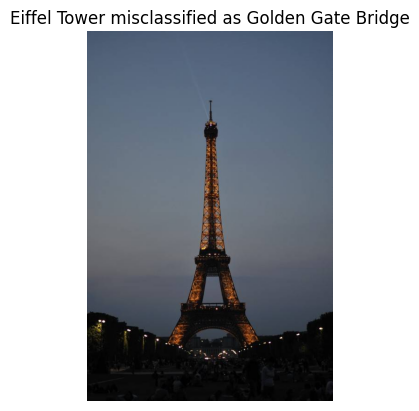

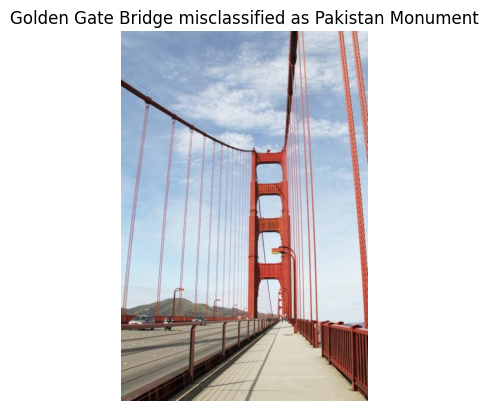

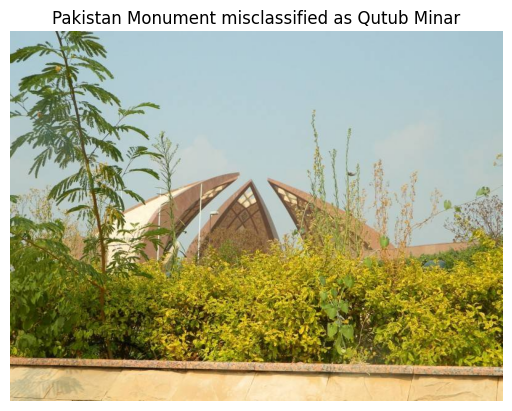

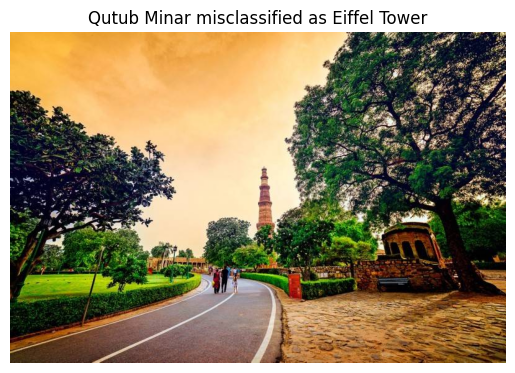

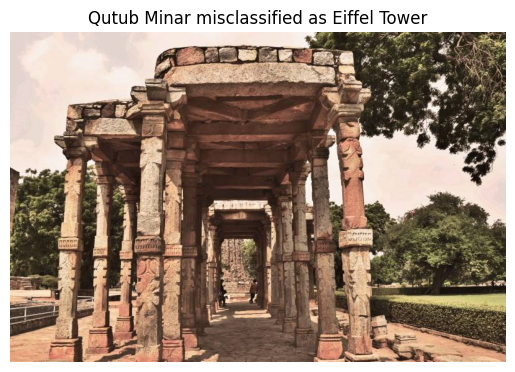

In [16]:
misclassified = np.where( labels_test!=finpreds )
for i in range(5):
    misidx = misclassified[0][i]
    imgid = test['id'][misidx]
    img = cv2.imread(img_path + str(imgid) + ".jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(str(TARGET_CLASSES_MAPPING[labels_test[misidx]]) +' misclassified as '  + str(TARGET_CLASSES_MAPPING[finpreds[misidx]]))
    plt.show()
    

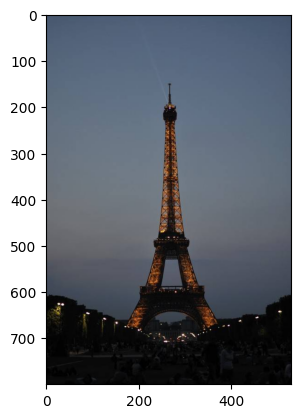

In [18]:
im = cv2.imread('../TargetImages/201edb4a52549725.jpg')
training_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB,0)
imgplot = plt.imshow(training_image, cmap='gray')


## Visual Look at the SIFT Features

### Histogram Representation

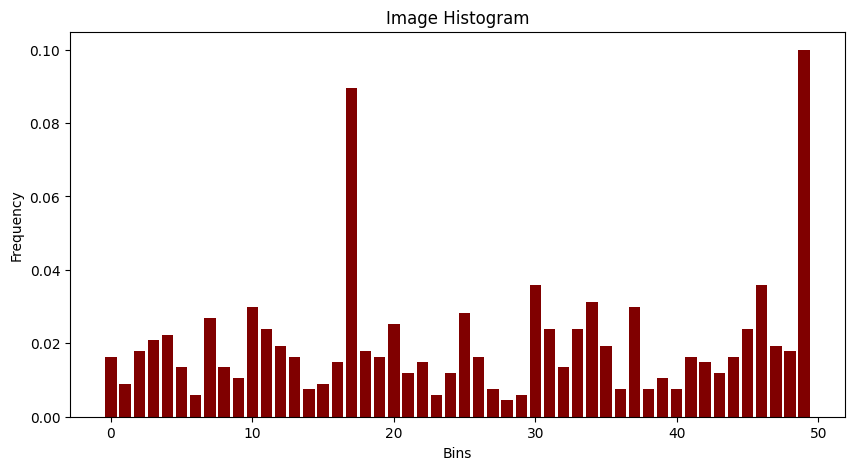

In [19]:
# Create our freq and bins from the vector coming out of the histogram generation
freq = histo_list[1]
bins = [i for i in range(len(freq))]

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(bins, freq, color ='maroon')
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()

### SIFT Features Key Points

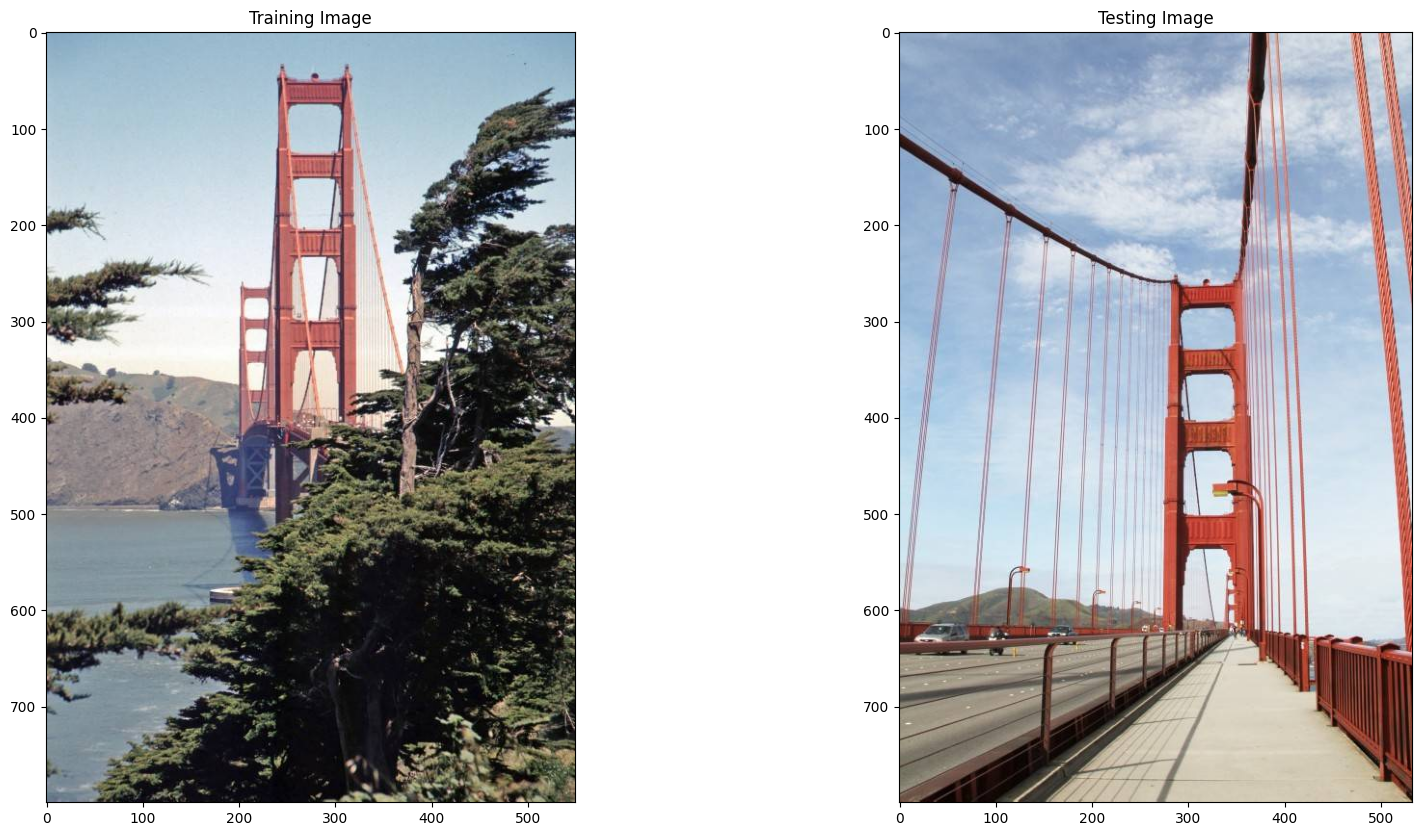

In [20]:


im1 = cv2.imread('../TargetImages/937bc82bcbd48c06.jpg')

im2 = cv2.imread('../TargetImages/edf37773bfa2d899.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Convert the training image to RGB
testing_image = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
testing_gray = cv2.cvtColor(testing_image, cv2.COLOR_RGB2GRAY)

# # Create test image by adding Scale Invariance and Rotational Invariance
# test_image = cv2.pyrDown(training_image)
# test_image = cv2.pyrDown(test_image)
# num_rows, num_cols = test_image.shape[:2]

# rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
# test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

# test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(testing_image)


Number of Keypoints Detected In The Training Image:  4991
Number of Keypoints Detected In The Query Image:  1352


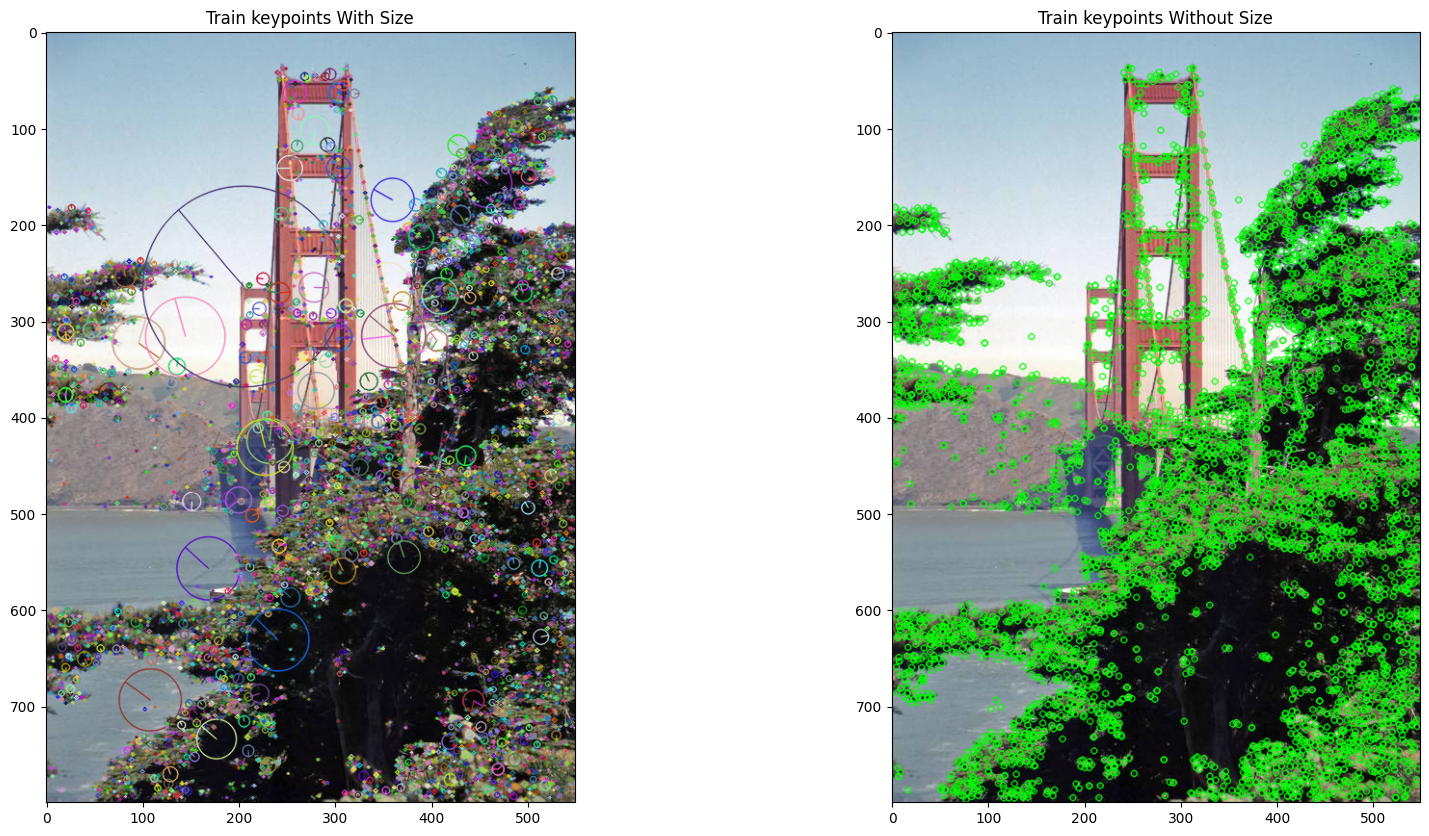

In [21]:
sift = cv2.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(testing_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

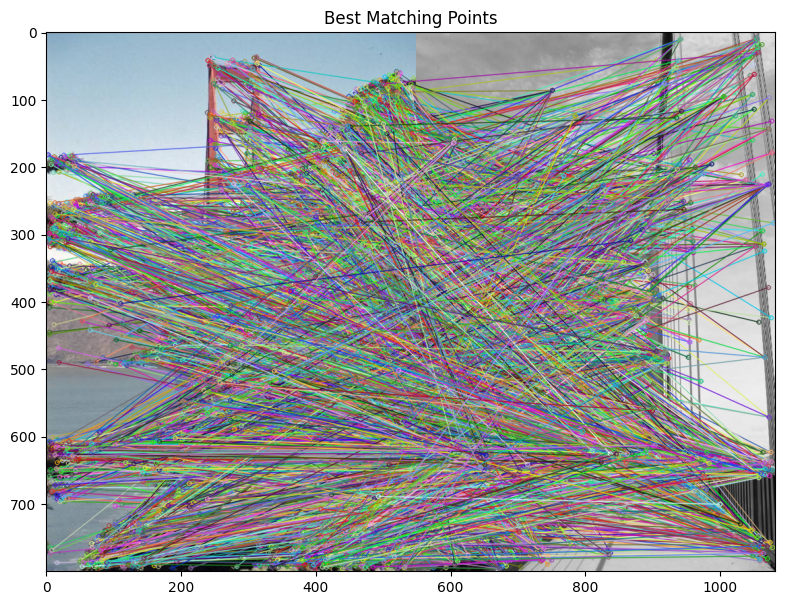


Number of Matching Keypoints Between The Training and Query Images:  4991


In [22]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, testing_gray, test_keypoints, matches, testing_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

### TSNE Visualization of the histogram Features

/Users/vtanna/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vtanna/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


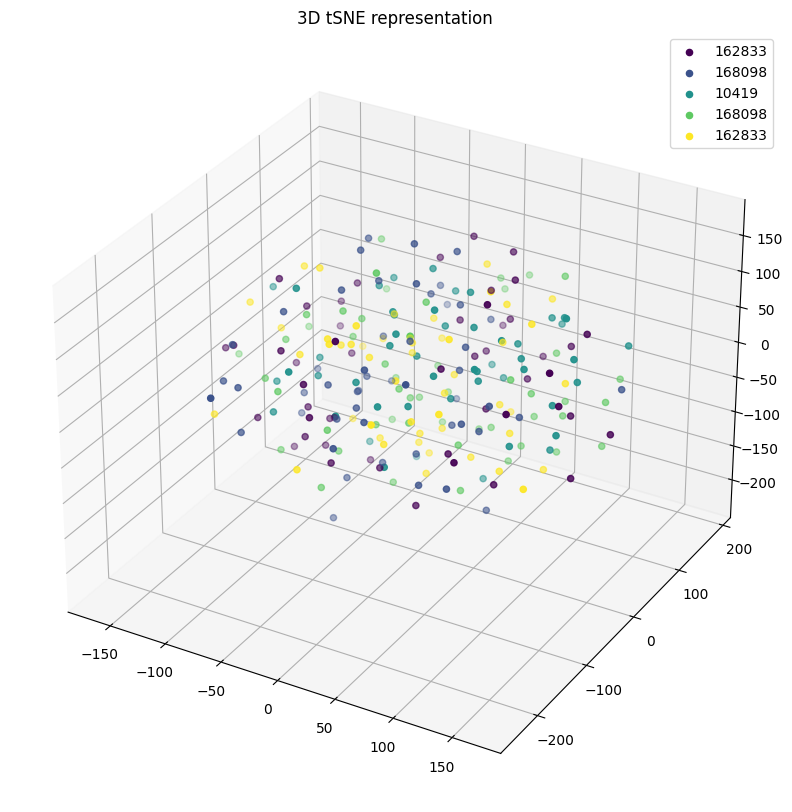

In [23]:
tsne = TSNE(n_components=3, random_state=0)
TX = tsne.fit_transform(X)
Ty = np.unique(Y)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
viridis = cm.get_cmap('viridis')
colors = np.linspace(0,1,5)
for i,c,l in zip(Ty, colors, Y):
    ax.scatter (
        TX[Y==i,0],
        TX[Y==i,1],
        TX[Y==i,2],
        color=viridis(c),
        label=l,
    )
plt.title('3D tSNE representation')
plt.legend()

/Users/vtanna/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vtanna/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


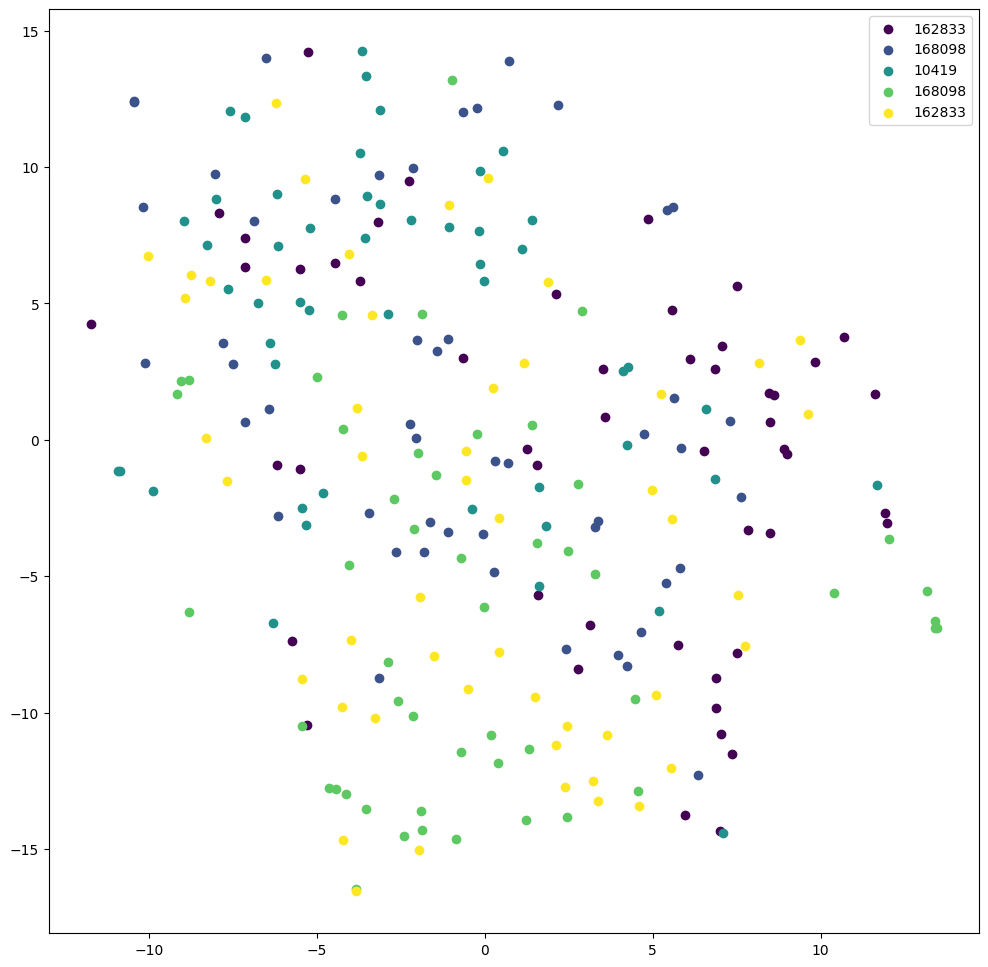

In [24]:
tsne = TSNE(n_components=2, random_state=0)
TX = tsne.fit_transform(X)
Ty = np.unique(Y)
fig = plt.figure(figsize=(12, 12))
viridis = cm.get_cmap('viridis')
colors = np.linspace(0,1,5)
for i,c,l in zip(Ty, colors, Y):
    plt.scatter (
        TX[Y==i,0],
        TX[Y==i,1],
        color=viridis(c),
        label=l,
    )
plt.legend()